In [1]:
import pandas as pd
import numpy as np
from sodapy import Socrata
import requests
import requests.auth as auth
import json

In [2]:
# Get a Socrata client to pull Turnstyle data
client = Socrata("data.ny.gov", None)

# Read in name of each subway, and its lat long information
subway_to_latlong = pd.read_csv("subway.csv")

# Read in census, median income data
census_to_median_income = pd.read_csv('census_data/census_data.csv')
# Quickly look at the data to make sure the read in was fine
census_to_median_income.head(2)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,3,4,6,7,10,11,14,15,18,19,22,23,26,27,30,31,32,38,39,40,42,43,46,47,50,51,54,55,56,58,59,62,63,64,66,67,70,71,72,74,75,78,79,82,83,86,87,90,91,94,95,102,103,104,106,107,110,111,114,115,118,119,122,123,126,127,128,130,131,134,135,138,139,142,143,146,147,150,151,154,155,158,159,162,163,166,167,170,171,174,175,178,179,182,183,184,186,187,190,191,194,195,198,199,202,203,204,206,207,210,211,214,215,218,219,222,223,226,227,230,231,234,235,238,239,242,243,254,255,262,263,270,271,278,279,286,287,294,295,298,299,300,302,303,306,307,310,311,314,315,318,319,322,323,326,327,330,331,334,335,338,339,354,355,356,378,379,380,382,383,386,387,390,391,394,395,398,399,400,402,403,406,407,408,410,411,412,414,415,416,418,419,422,423,426,427,430,431,434,435,436,438,439,442,443,446,447,450,451,454,455,456,458,459,462,463,466,467,470,471) have mixed types.Specify dtype option on import or set low_memory=False

,GEO_ID,NAME,DP03_0001E,DP03_0001M,DP03_0001PE,DP03_0001PM,DP03_0002E,DP03_0002M,DP03_0002PE,DP03_0002PM,...,DP03_0135PE,DP03_0135PM,DP03_0136E,DP03_0136M,DP03_0136PE,DP03_0136PM,DP03_0137E,DP03_0137M,DP03_0137PE,DP03_0137PM
0,id,Geographic Area Name,Estimate!!EMPLOYMENT STATUS!!Population 16 yea...,Margin of Error!!EMPLOYMENT STATUS!!Population...,Percent Estimate!!EMPLOYMENT STATUS!!Populatio...,Percent Margin of Error!!EMPLOYMENT STATUS!!Po...,Estimate!!EMPLOYMENT STATUS!!Population 16 yea...,Margin of Error!!EMPLOYMENT STATUS!!Population...,Percent Estimate!!EMPLOYMENT STATUS!!Populatio...,Percent Margin of Error!!EMPLOYMENT STATUS!!Po...,...,Percent Estimate!!PERCENTAGE OF FAMILIES AND P...,Percent Margin of Error!!PERCENTAGE OF FAMILIE...,Estimate!!PERCENTAGE OF FAMILIES AND PEOPLE WH...,Margin of Error!!PERCENTAGE OF FAMILIES AND PE...,Percent Estimate!!PERCENTAGE OF FAMILIES AND P...,Percent Margin of Error!!PERCENTAGE OF FAMILIE...,Estimate!!PERCENTAGE OF FAMILIES AND PEOPLE WH...,Margin of Error!!PERCENTAGE OF FAMILIES AND PE...,Percent Estimate!!PERCENTAGE OF FAMILIES AND P...,Percent Margin of Error!!PERCENTAGE OF FAMILIE...
1,1400000US36001000100,"Census Tract 1, Albany County, New York",1505,176,1505,(X),930,172,61.8,7.7,...,10.5,6.2,(X),(X),29.1,15.5,(X),(X),41.3,12.0


In [3]:
# A function that takes in a lat long, and using the fcc api, turns that into the census tract the station belongs to
def lat_long_to_census_tract(lat, long):
    format_str = "https://geo.fcc.gov/api/census/area?lat={}&lon={}&format=json".format(lat, long)
    response = requests.get(format_str)
    # If the lat long belongs to two census tracts, take the first one (TODO: think more about this later)
    # and return the census tract id that is formatted the way 
    # the American Community Survey expects, which is the first 11 digits of the block id. 
    return response.json()['results'][0]['block_fips'][0:11]

# A function that takes in the census tract id, turns it into the GEO_ID that the ACS dataset requires, and gives back the 
# median household income there
# TODO: Build hash to make it O(1) instead of O(n)
def census_tract_to_median_income_dollars(census_tract):
    # from the headers file, find the column name for median household income
    name_of_median_income_col = 'DP03_0062E'
    # convert to geo id
    geo_id = "1400000US"+census_tract
    
    # filter dataframe to those matching the geo id
    median_income_in_census_tract = census_to_median_income[census_to_median_income["GEO_ID"]==geo_id]
    
    # If there is an error, throw out that value
    # TODO: look at this again
    if median_income_in_census_tract[name_of_median_income_col].values[0]== '-':
        return None
    
    # If its a string that denotes the median income is greater than 250,000, code that as 250,001 and make a note
    # in the piece that this is all that the ACS collects
    if median_income_in_census_tract[name_of_median_income_col].values[0]== '250,000+':
        return 250001
    
    return int(median_income_in_census_tract[name_of_median_income_col].values[0])

# test line
# census_tract_to_median_income_dollars("36001000200")

In [4]:
# Look at the subway to latlong file
subway_to_latlong.head(2)

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label
0,1,1,R01,BMT,Astoria,Astoria - Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034,NaN,Manhattan
1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843,Ditmars Blvd,Manhattan


In [5]:
# Method to build and return a hash where the key is the subway station name, and by using the helper functions above,
# the value is the median income near that subway station for the census tract its in
def build_station_to_med_income():
    station_to_median_income = {}
    # for each subway station
    for index, row in subway_to_latlong.iterrows():
        # get what census tract its in
        row_census_tract = lat_long_to_census_tract(row["GTFS Latitude"], row['GTFS Longitude'])
        # get the median income of that census tract and build the dictionary
        station_to_median_income[row['Stop Name']] = census_tract_to_median_income_dollars(row_census_tract)
    return station_to_median_income
# store this dictionary once so we dont keep recomputing
station_to_med_income = build_station_to_med_income()

In [6]:
# Pull the turnstyle data, sample one working day in October to estimate commuters by station
# TODO: change this to an average over a few weeks of working days
# limit defaults to 1000, so I searched for a limit amount that comfortably got all the results
turnstile_results = client.get("xfn5-qji9", date='2019-10-24T00:00:00.000', limit=35000)

In [7]:
turnstiles_df = pd.DataFrame.from_records(turnstile_results)
# check that I'm getting all the possible results
turnstiles_df.shape[0]

29320

In [8]:
# get the number of stations in the station to median income dict
len(station_to_med_income)

377

In [9]:
# Look at some of the data for a particular station
turnstiles_df[turnstiles_df['station']=="SOUTH FERRY"].head(2)

,c_a,unit,scp,station,line_name,division,date,time,description,entries,exits
18254,R101,R001,02-00-00,SOUTH FERRY,1RW,IRT,2019-10-24T00:00:00.000,01:00:00,REGULAR,6853691,43849
18255,R101,R001,02-00-00,SOUTH FERRY,1RW,IRT,2019-10-24T00:00:00.000,05:00:00,REGULAR,6853715,43898


In [10]:
# get the number of station in the turnstile data to compare against stations I have in the median income dict
# it matches
len(turnstiles_df['station'].unique())

377

In [11]:
# This function builds a hash where the key is the station name and the value is the 
# morning commuters entering at that station
def build_station_to_morning_turnstile():
    station_to_turnstile_num = {}
    # for each station in the turnstiles dataset
    for station in turnstiles_df['station'].unique():
        
        # TODO: check if it is catching multiple time stamps within the range
        # query for entries between 10 and 1 and enteries between 4 and 6:30am since the 
        # turnstiles data is cumalitive starting at the begining of the year, so subtract the morning data
        # from the noon data to see how much traffic the station got in entries in the morning
        enteries_at_noon = turnstiles_df.query("station == \""+station+"\" and time >= \"10:00:00\" and time <= \"13:00:00\"")['entries'].astype(int).sum()
        enteries_at_4 = turnstiles_df.query("station == \""+station+"\" and time >= \"04:00:00\" and time <= \"06:30:00\"")['entries'].astype(int).sum()
        
        # some quick checks to catch cases that should never happen
        assert enteries_at_noon != 0, station
        assert enteries_at_4 != 0, station
        
        # estimating morning traffic
        difference_between_morning = int(enteries_at_noon) - int(enteries_at_4)
        
        # TODO: These stations have weird data, throwing it out right now and will deal with later
        try:
            assert difference_between_morning > 0, station + " {}".format(difference_between_morning)
        except:
            # log every problematic station for further inspection
            print("Station errored: " + station)
            continue
            
        # after the try catch this should never happen, when dealt with later, pull out the above try catch
        assert difference_between_morning > 0, station + " {}".format(difference_between_morning)
        
        station_to_turnstile_num[station] = difference_between_morning
    return station_to_turnstile_num

In [12]:
# store the dictionary
station_to_morning_dict = build_station_to_morning_turnstile()

Station errored: 6 AV
Station errored: PAVONIA/NEWPORT
Station errored: 9TH STREET
Station errored: THIRTY ST
Station errored: PATH WTC 2
Station errored: SOUTH FERRY
Station errored: 149/GRAND CONC


In [13]:
station_to_morning_dict

{'59 ST': 17750,
 '5 AV/59 ST': 761,
 '57 ST-7 AV': 6465,
 '49 ST': 3528,
 'TIMES SQ-42 ST': 20052,
 '34 ST-HERALD SQ': 27670,
 '28 ST': 12690,
 '23 ST': 30343,
 '14 ST-UNION SQ': 23553,
 '8 ST-NYU': 4715,
 'PRINCE ST': 1864,
 'CANAL ST': 12736,
 'CITY HALL': 1084,
 'CORTLANDT ST': 5497,
 'RECTOR ST': 4962,
 'WHITEHALL S-FRY': 6172,
 'DELANCEY/ESSEX': 10791,
 'BOWERY': 742,
 'CHAMBERS ST': 11971,
 'FULTON ST': 4006727920,
 'BROAD ST': 1103,
 '7 AV': 17518,
 'PARK PLACE': 1408,
 'BOTANIC GARDEN': 535,
 'PROSPECT PARK': 6634,
 'PARKSIDE AV': 4277,
 'CHURCH AV': 23793,
 'BEVERLEY ROAD': 2555,
 'CORTELYOU RD': 4447,
 'NEWKIRK PLAZA': 7811,
 'AVENUE H': 1943,
 'AVENUE J': 3521,
 'AVENUE M': 3230,
 'KINGS HWY': 19156,
 'AVENUE U': 8846,
 'NECK RD': 3512,
 'SHEEPSHEAD BAY': 9690,
 'BRIGHTON BEACH': 6201,
 'OCEAN PKWY': 1795,
 'BOROUGH HALL': 11592,
 'JAY ST-METROTEC': 10462,
 'DEKALB AV': 13057,
 'ATL AV-BARCLAY': 19164,
 'UNION ST': 3945,
 '4AV-9 ST': 4850,
 'PROSPECT AV': 7862,
 '25 ST': 21

In [14]:
# do a dumb version of fuzzy matching right now to compare the station names across the datasets
# TODO: make this fuzzy matching better here

#rebuild dictionaries with lower case and stripped keys
corrected_station_name_to_commute_dict = {}
for key, value in station_to_morning_dict.items():
    lower = key.lower()
    strip_spaces = lower.replace(" ","").replace("-","").replace("/","")
    corrected_station_name_to_commute_dict[strip_spaces] = value
    
corrected_station_name_to_median_inc = {}
for key, value in station_to_med_income.items():
    lower = key.lower()
    strip_spaces = lower.replace(" ","").replace("-","").replace("/", "")
    corrected_station_name_to_median_inc[strip_spaces] = value

In [15]:
# join the dictionaries by searching for keys that match
joined_dict = {}
for key, value in corrected_station_name_to_commute_dict.items():
    if key in corrected_station_name_to_median_inc.keys():
        if corrected_station_name_to_median_inc[key] is None:
            continue
        joined_dict[key]=[corrected_station_name_to_median_inc[key], value]
        
# how many actually matched out of 377?
len(joined_dict)

249

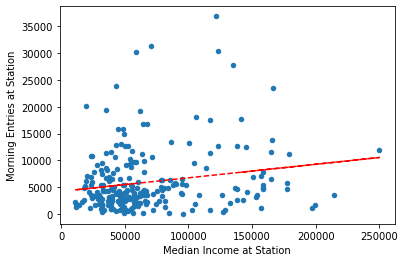

In [16]:
# Make a scatter plot with Morning Enteries at a station vs. the median income at the station
median_income_str = 'Median Income at Station'
morning_entries_str = 'Morning Entries at Station'
median_income_commute_df = pd.DataFrame(joined_dict.values(), columns=[median_income_str, morning_entries_str])

# Throw out weird outlier TODO: investigate why there are some weird outliers
median_income_commute_df = median_income_commute_df[median_income_commute_df[morning_entries_str]<2e7]

plot = median_income_commute_df.plot.scatter(x=median_income_str, y=morning_entries_str)
x = median_income_commute_df[median_income_str]

# build a trend line to overlay
z = np.polyfit(x, median_income_commute_df[morning_entries_str], 1)
p = np.poly1d(z)
plot.plot(x,p(x),"r--")

In [17]:
# The Cost of 30 day unlimited pass in 2016 and 2019
cost_30_day_unlimited_2019 = 127
cost_30_day_unlimited_2016 = 116.50
# The Federal Poverty Lines in 2016 and 2019
fpl_2016 = 11880
fpl_2019 = 12490

In [18]:
# Percent of income spend on transportation for a 30 day unlimited pass if you are at the federal poverty line in 2016
pct_of_income_transportation_2016 = cost_30_day_unlimited_2016*12*100/fpl_2016

In [19]:
# Percent of income spend on transportation for a 30 day unlimited pass if you are at the federal poverty line in 2016
pct_of_income_transportation_2019 = cost_30_day_unlimited_2019*12*100/fpl_2019

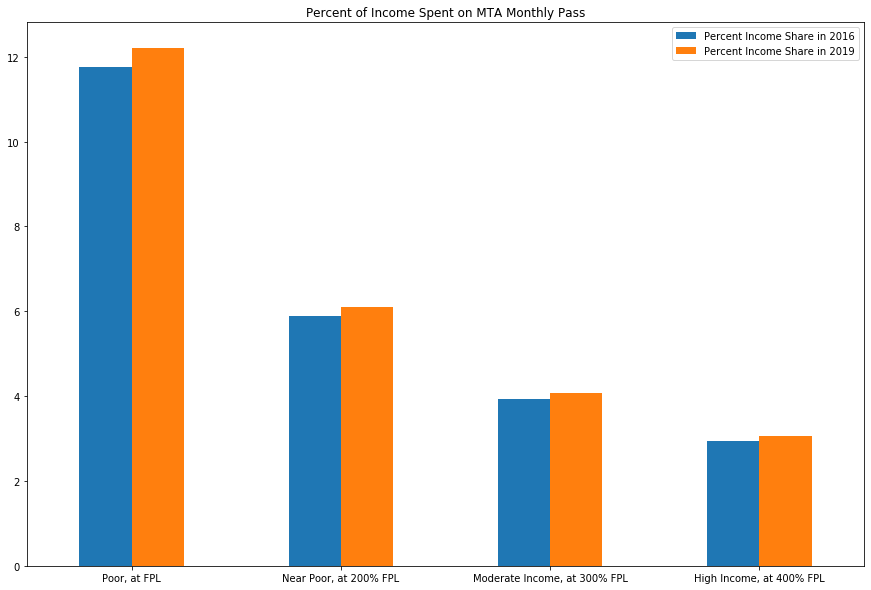

In [20]:
# Column names
column_names = ['Poor, at FPL', 'Near Poor, at 200% FPL', 'Moderate Income, at 300% FPL', 'High Income, at 400% FPL']
# array with percent of 2016 FPL at different levels of income
pct_2016_FPL = [pct_of_income_transportation_2016, pct_of_income_transportation_2016/2, pct_of_income_transportation_2016/3, pct_of_income_transportation_2016/4]
# array with percent of 2019 FPL at different levels of income
pct_2019_FPL = [pct_of_income_transportation_2019, pct_of_income_transportation_2019/2, pct_of_income_transportation_2019/3, pct_of_income_transportation_2019/4]
# build the dataframe
df = pd.DataFrame({'Percent Income Share in 2016': pct_2016_FPL,
                   'Percent Income Share in 2019': pct_2019_FPL}, index=column_names)
# show the chart 
ax = df.plot.bar(rot=0, figsize=(15,10), title="Percent of Income Spent on MTA Monthly Pass")